In [3]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
import seaborn as sns
import ternary
from toolbox import hillshade
import rasterio as rio
%matplotlib inline

import xarray as xr

import glob
import os
import pandas as pd

In [4]:
def plot_corr(dataframe, size=10):
    plt.figure(figsize = (size+size*0.2, size), facecolor='w')
    corrMatrix = dataframe.corr()
    sns.heatmap(np.round(corrMatrix,2), annot=True)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0, ha='right')

In [5]:
def compute_pca(df, variables, explained_variance='on'):
    
    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    X = df.loc[:, variables].values
    mu_ = np.mean(X, axis=0)
    sd_ = np.std(X, axis=0)
    scaler = StandardScaler()
    x = scaler.fit_transform(X)
    
    n_components = len(variables)
    pca = PCA(n_components=n_components, whiten=True)
    pca.fit(x)
    
    n_pcs = np.arange(1, len(variables)+1)
    pc = ['PC']*(len(variables) + 1)

    PCs = []
    for i, k in zip(pc, n_pcs):
        PCs.append(i+str(k))
        
    PC_transformed = []
    for i in range(len(variables)):
        pc_dot = np.dot(pca.transform(x)[:,:i+1], pca.components_[:i+1,:])
        pc_dot_ = sd_*pc_dot + mu_
        PC_transformed.append(pc_dot_)
    
    pcs = np.array(PC_transformed)
        
    fig, ax=plt.subplots(figsize=(len(variables), len(variables)))
    im=ax.matshow(pca.components_,cmap='plasma')
    for (i, j), z in np.ndenumerate(pca.components_):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    fig.colorbar(im, label='Eigenvalues')
    plt.gca().set_aspect('equal')
    plt.gcf().set_size_inches(10, 8)
    plt.yticks(range(len(variables)), PCs,fontsize=9)
    plt.xticks(range(len(variables)), variables,rotation=55,fontsize = 10, ha='left')
    plt.tight_layout()
    plt.show()
    
    if explained_variance == 'on':
        plt.figure(figsize=(8, 4), facecolor='w')
        plt.bar(PCs,pca.explained_variance_ratio_ *100, color='orangered')
        plt.xticks(rotation = 90)
        plt.ylabel('Variance explained by component (%)')
        plt.grid(which='both', linewidth=0.4)
    
    return pcs

### Importing XYZ remote sensing dataset

In [6]:
MDT = pd.read_csv('/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/test.csv')
MDT= MDT.drop('Unnamed: 3',axis=1)
#df_1= df_1.drop('Z',axis=1)

In [7]:
MDT

,X,Y,MDT
0,398336.153139,9.502136e+06,301.0
1,398366.926714,9.502136e+06,299.0
2,398397.700289,9.502136e+06,300.0
3,398428.473864,9.502136e+06,300.0
4,398459.247439,9.502136e+06,300.0
...,...,...,...
446035,421447.108058,9.484010e+06,470.0
446036,421477.881634,9.484010e+06,474.0
446037,421508.655209,9.484010e+06,478.0
446038,421539.428784,9.484010e+06,480.0


In [6]:
# the path to your csv file directory
mycsvdir = '/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo'

# get all the csv files in that directory (assuming they have the extension .csv)
csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))
for csvfile in csvfiles:
    print(csvfile,end='\n')

/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/pontosstq_AST_13-05-2004.csv
/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/pontossqt_LC08_Level_2_20-09-2022.csv
/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/pontossqt_gama_ternario.csv
/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/test.csv
/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/pontossqt_magnetometria_tilt_e_derivada_vertical.csv
/home/ggrl/usp/4-ano/remote-sensing/tf/csv/segundo/pontossqt_LC08_Level_2_08-02-2019.csv


In [12]:
# loop through the files and read them in with pandas
dataframes = []  # a list to hold all the individual pandas DataFrames

for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    print(df.head())
    dataframes.append(df)

     MDT  _1  _2   _3  _4  _5  _6  _7  _8  _9   _10   _11   _12   _13   _14
0  301.0  71  42  100  61  32  34  30  24  20  1225  1337  1442  1688  1760
1  299.0  77  43  109  62  34  36  31  25  20  1225  1337  1442  1688  1760
2  300.0  72  42   99  64  33  36  32  26  22  1232  1350  1451  1698  1773
3  300.0  69  40   95  62  33  36  31  26  19  1232  1350  1451  1698  1773
4  300.0  71  40  104  61  33  34  30  26  21  1232  1350  1451  1698  1773
     MDT    _1    _2    _3     _4     _5     _6     _7     _8
0  301.0  8580  9047  9792  10884  14749  19507  14810  50174
1  299.0  8567  9027  9833  11040  15272  19590  14836  50227
2  300.0  8550  9001  9781  10958  15157  20128  15179  50243
3  300.0  8561  8995  9703  10828  14711  19496  14830  50252
4  300.0  8610  9018  9771  10807  14632  19157  14719  50252
     MDT   _1  _2  _3
0  301.0  128  48  24
1  299.0  136  48  16
2  300.0  136  48  16
3  300.0  136  48  16
4  300.0  144  48  16
               X             Y    MDT  U

In [8]:
result = pd.concat(dataframes, ignore_index=True,axis=1)
result
#result.to_csv('/home/ggrl/usp/4-ano/remote-sensing/tf/csv/all.csv')

ValueError: No objects to concatenate

In [8]:
df_result = pd.concat([df_1,result], axis=1)

In [9]:
df_result

,X,Y,MDT,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,398336.153139,9.502136e+06,301.0,301.0,71,42,100,61,32,34,...,81,301.0,8266,8316,9813,8560,20922,15306,10883,45775
1,398366.926714,9.502136e+06,299.0,299.0,77,43,109,62,34,36,...,98,299.0,8326,8414,9824,8721,20703,15579,11100,45809
2,398397.700289,9.502136e+06,300.0,300.0,72,42,99,64,33,36,...,113,300.0,8328,8411,9791,8728,19463,15596,11182,45836
3,398428.473864,9.502136e+06,300.0,300.0,69,40,95,62,33,36,...,127,300.0,8277,8359,9653,8654,19398,15290,11009,45827
4,398459.247439,9.502136e+06,300.0,300.0,71,40,104,61,33,34,...,132,300.0,8311,8383,9748,8649,20212,15361,11009,45804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,421447.108058,9.484010e+06,470.0,470.0,216,165,145,118,94,106,...,156,470.0,8164,8294,9596,8771,19254,15060,11010,46010
446036,421477.881634,9.484010e+06,474.0,474.0,192,147,134,102,82,86,...,147,474.0,8092,8172,9479,8478,20301,14589,10560,45966
446037,421508.655209,9.484010e+06,478.0,478.0,229,177,148,90,70,77,...,136,478.0,8049,8178,9552,8522,20100,14531,10529,46012
446038,421539.428784,9.484010e+06,480.0,480.0,166,123,118,87,65,72,...,122,480.0,8087,8204,9630,8534,20389,14776,10660,46013


In [10]:
df_result

,X,Y,MDT,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,398336.153139,9.502136e+06,301.0,301.0,71,42,100,61,32,34,...,81,301.0,8266,8316,9813,8560,20922,15306,10883,45775
1,398366.926714,9.502136e+06,299.0,299.0,77,43,109,62,34,36,...,98,299.0,8326,8414,9824,8721,20703,15579,11100,45809
2,398397.700289,9.502136e+06,300.0,300.0,72,42,99,64,33,36,...,113,300.0,8328,8411,9791,8728,19463,15596,11182,45836
3,398428.473864,9.502136e+06,300.0,300.0,69,40,95,62,33,36,...,127,300.0,8277,8359,9653,8654,19398,15290,11009,45827
4,398459.247439,9.502136e+06,300.0,300.0,71,40,104,61,33,34,...,132,300.0,8311,8383,9748,8649,20212,15361,11009,45804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,421447.108058,9.484010e+06,470.0,470.0,216,165,145,118,94,106,...,156,470.0,8164,8294,9596,8771,19254,15060,11010,46010
446036,421477.881634,9.484010e+06,474.0,474.0,192,147,134,102,82,86,...,147,474.0,8092,8172,9479,8478,20301,14589,10560,45966
446037,421508.655209,9.484010e+06,478.0,478.0,229,177,148,90,70,77,...,136,478.0,8049,8178,9552,8522,20100,14531,10529,46012
446038,421539.428784,9.484010e+06,480.0,480.0,166,123,118,87,65,72,...,122,480.0,8087,8204,9630,8534,20389,14776,10660,46013


In [11]:
geotiff_path ='/home/ggrl/usp/4-ano/remote-sensing/tf/tf_dados/tif/AST/stq_AST_13-05-2004.tif'
geotiff_da = xr.open_rasterio(geotiff_path)
#geotiff_da
geotiff_ds = geotiff_da.to_dataset('band')
geotiff_df = geotiff_ds.to_dataframe()
#geotiff_df.head()
geotiff_df = geotiff_df.reset_index()
#geotiff_dfls

df_rs =geotiff_df

df_rs = df_rs.rename(columns={1:"VNIR_Band1",
                      2:"VNIR_Band2",
                      3:"VNIR_Band3N",
                      4:"SWIR_Band4",
                      5:"SWIR_Band5",
                      6:"SWIR_Band6",
                      7:"SWIR_Band7",
                      8:"SWIR_Band8",
                      9:"SWIR_Band9",
                      10:"TIR_Band10",
                      11:"TIR_Band11",
                      12:"TIR_Band1",
                      13:"TIR_Band13",
                      14:"TIR_Band14"})

df_ASTER = df_rs.rename(columns={'x':'E_utm','y':'N_utm'})
df_ASTER.head()

/tmp/ipykernel_20948/321592489.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_da = xr.open_rasterio(geotiff_path)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


,N_utm,E_utm,VNIR_Band1,VNIR_Band2,VNIR_Band3N,SWIR_Band4,SWIR_Band5,SWIR_Band6,SWIR_Band7,SWIR_Band8,SWIR_Band9,TIR_Band10,TIR_Band11,TIR_Band1,TIR_Band13,TIR_Band14
0,9502517.5,397852.5,0,0,0,0,0,0,0,0,0,1156,1251,1356,1608,1686
1,9502517.5,397867.5,0,0,0,0,0,0,0,0,0,1156,1251,1356,1608,1686
2,9502517.5,397882.5,0,0,0,77,57,62,57,56,41,1156,1251,1356,1608,1686
3,9502517.5,397897.5,0,0,0,77,57,62,57,56,41,1156,1251,1356,1608,1686
4,9502517.5,397912.5,0,0,0,74,52,57,53,49,36,1156,1251,1356,1608,1686


In [12]:
df_ASTER.head()

,N_utm,E_utm,VNIR_Band1,VNIR_Band2,VNIR_Band3N,SWIR_Band4,SWIR_Band5,SWIR_Band6,SWIR_Band7,SWIR_Band8,SWIR_Band9,TIR_Band10,TIR_Band11,TIR_Band1,TIR_Band13,TIR_Band14
0,9502517.5,397852.5,0,0,0,0,0,0,0,0,0,1156,1251,1356,1608,1686
1,9502517.5,397867.5,0,0,0,0,0,0,0,0,0,1156,1251,1356,1608,1686
2,9502517.5,397882.5,0,0,0,77,57,62,57,56,41,1156,1251,1356,1608,1686
3,9502517.5,397897.5,0,0,0,77,57,62,57,56,41,1156,1251,1356,1608,1686
4,9502517.5,397912.5,0,0,0,74,52,57,53,49,36,1156,1251,1356,1608,1686


In [13]:
df_ASTER.describe()

,N_utm,E_utm,VNIR_Band1,VNIR_Band2,VNIR_Band3N,SWIR_Band4,SWIR_Band5,SWIR_Band6,SWIR_Band7,SWIR_Band8,SWIR_Band9,TIR_Band10,TIR_Band11,TIR_Band1,TIR_Band13,TIR_Band14
count,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06,2.018520e+06
mean,9.493075e+06,4.098600e+05,8.064838e+01,5.020109e+01,1.094051e+02,6.027314e+01,3.501877e+01,3.690502e+01,3.299318e+01,2.854435e+01,2.324196e+01,1.203665e+03,1.307193e+03,1.413009e+03,1.660427e+03,1.738068e+03
std,5.455960e+03,6.936864e+03,3.668294e+01,3.642483e+01,2.396590e+01,1.542048e+01,1.392441e+01,1.613375e+01,1.505682e+01,1.573537e+01,1.070579e+01,5.015345e+01,5.982887e+01,6.587791e+01,6.403655e+01,6.111453e+01
min,9.483632e+06,3.978525e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.800000e+02,1.050000e+03,1.129000e+03,1.381000e+03,1.471000e+03
25%,9.488354e+06,4.038525e+05,6.800000e+01,3.700000e+01,9.900000e+01,5.500000e+01,2.900000e+01,3.000000e+01,2.700000e+01,2.200000e+01,1.900000e+01,1.185000e+03,1.283000e+03,1.386000e+03,1.634000e+03,1.715000e+03
50%,9.493075e+06,4.098600e+05,7.200000e+01,4.000000e+01,1.090000e+02,5.900000e+01,3.200000e+01,3.300000e+01,2.900000e+01,2.400000e+01,2.000000e+01,1.210000e+03,1.314000e+03,1.420000e+03,1.667000e+03,1.746000e+03
75%,9.497796e+06,4.158675e+05,7.700000e+01,4.500000e+01,1.200000e+02,6.300000e+01,3.600000e+01,3.700000e+01,3.300000e+01,2.800000e+01,2.200000e+01,1.234000e+03,1.344000e+03,1.454000e+03,1.699000e+03,1.775000e+03
max,9.502518e+06,4.218675e+05,2.550000e+02,2.550000e+02,2.550000e+02,1.770000e+02,1.370000e+02,1.610000e+02,1.490000e+02,1.460000e+02,1.030000e+02,1.372000e+03,1.527000e+03,1.658000e+03,1.888000e+03,1.941000e+03


## SENSORES

#### Computing NDVI

In [14]:
# Ndvi - 1984
NDVI = np.array(((df_rs.ASTER_NIR_1984 - df_rs.ASTER_RED_1984) + 1)/((df_rs.ASTER_NIR_1984 + df_rs.ASTER_RED_1984) + 1))
df_rs['NDVI_1984'] = (NDVI - NDVI.mean())/NDVI.std()

# Ndvi - 1986
NDVI = np.array(((df_rs.ASTER_NIR_1986 - df_rs.ASTER_RED_1986) + 1)/((df_rs.ASTER_NIR_1986 + df_rs.ASTER_RED_1986) + 1))
df_rs['NDVI_1986'] = (NDVI - NDVI.mean())/NDVI.std()

# Ndvi - 2004-2005
NDVI = np.array(((df_rs.NIR - df_rs.RED) + 1)/((df_rs.NIR + df_rs.RED) f/AST/stq_AST_13-05-+ 1))
df_rs['NDVI_2004'] = (NDVI - NDVI.mean())/NDVI.std()
# Ndvi - 2021
NDVI = np.array(((df_rs.OLI_NIR - df_rs.OLI_RED) + 1)/((df_rs.OLI_NIR + df_rs.OLI_RED) + 1))
df_rs['NDVI_2021'] = (NDVI - NDVI.mean())/NDVI.std()

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (1441942782.py, line 10)

### Pixel size

In [15]:
df_result

,X,Y,MDT,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,398336.153139,9.502136e+06,301.0,301.0,71,42,100,61,32,34,...,81,301.0,8266,8316,9813,8560,20922,15306,10883,45775
1,398366.926714,9.502136e+06,299.0,299.0,77,43,109,62,34,36,...,98,299.0,8326,8414,9824,8721,20703,15579,11100,45809
2,398397.700289,9.502136e+06,300.0,300.0,72,42,99,64,33,36,...,113,300.0,8328,8411,9791,8728,19463,15596,11182,45836
3,398428.473864,9.502136e+06,300.0,300.0,69,40,95,62,33,36,...,127,300.0,8277,8359,9653,8654,19398,15290,11009,45827
4,398459.247439,9.502136e+06,300.0,300.0,71,40,104,61,33,34,...,132,300.0,8311,8383,9748,8649,20212,15361,11009,45804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,421447.108058,9.484010e+06,470.0,470.0,216,165,145,118,94,106,...,156,470.0,8164,8294,9596,8771,19254,15060,11010,46010
446036,421477.881634,9.484010e+06,474.0,474.0,192,147,134,102,82,86,...,147,474.0,8092,8172,9479,8478,20301,14589,10560,45966
446037,421508.655209,9.484010e+06,478.0,478.0,229,177,148,90,70,77,...,136,478.0,8049,8178,9552,8522,20100,14531,10529,46012
446038,421539.428784,9.484010e+06,480.0,480.0,166,123,118,87,65,72,...,122,480.0,8087,8204,9630,8534,20389,14776,10660,46013


In [16]:
df_rs = df_result.rename(columns={'X':'E_utm','Y':'N_utm'})
df_rs

,E_utm,N_utm,MDT,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,398336.153139,9.502136e+06,301.0,301.0,71,42,100,61,32,34,...,81,301.0,8266,8316,9813,8560,20922,15306,10883,45775
1,398366.926714,9.502136e+06,299.0,299.0,77,43,109,62,34,36,...,98,299.0,8326,8414,9824,8721,20703,15579,11100,45809
2,398397.700289,9.502136e+06,300.0,300.0,72,42,99,64,33,36,...,113,300.0,8328,8411,9791,8728,19463,15596,11182,45836
3,398428.473864,9.502136e+06,300.0,300.0,69,40,95,62,33,36,...,127,300.0,8277,8359,9653,8654,19398,15290,11009,45827
4,398459.247439,9.502136e+06,300.0,300.0,71,40,104,61,33,34,...,132,300.0,8311,8383,9748,8649,20212,15361,11009,45804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,421447.108058,9.484010e+06,470.0,470.0,216,165,145,118,94,106,...,156,470.0,8164,8294,9596,8771,19254,15060,11010,46010
446036,421477.881634,9.484010e+06,474.0,474.0,192,147,134,102,82,86,...,147,474.0,8092,8172,9479,8478,20301,14589,10560,45966
446037,421508.655209,9.484010e+06,478.0,478.0,229,177,148,90,70,77,...,136,478.0,8049,8178,9552,8522,20100,14531,10529,46012
446038,421539.428784,9.484010e+06,480.0,480.0,166,123,118,87,65,72,...,122,480.0,8087,8204,9630,8534,20389,14776,10660,46013


In [17]:
xpixel_size = (df_rs.E_utm.max()-df_rs.E_utm.min())/df_rs.E_utm.unique().size
ypixel_size = (df_rs.N_utm.max()-df_rs.N_utm.min())/df_rs.N_utm.unique().size
print('x:', xpixel_size, 'y:', ypixel_size)

x: 30.73286933858336 y: 30.721416523354918


In [18]:
nx=df_rs.E_utm.unique().size
ny=df_rs.N_utm.unique().size
ratio=ny/nx
xs = df_rs.E_utm.values.reshape(ny, nx)
ys = df_rs.N_utm.values.reshape(ny, nx)

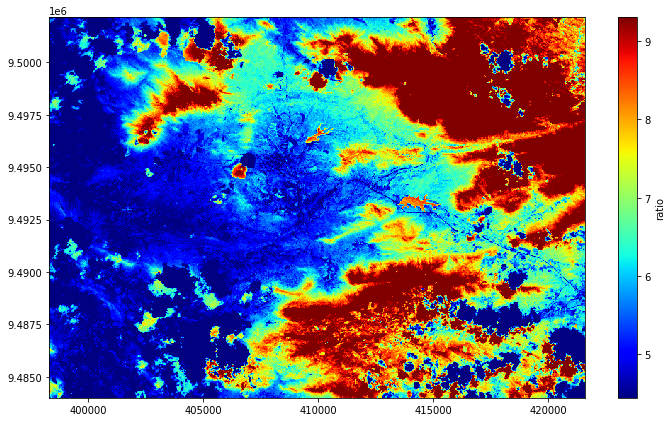

In [19]:
var = np.array((df_rs[0]. values+1)/(df_rs[1].values+1)).reshape(ny, nx)
plt.figure(figsize=(12, int(ratio * 10)))
plt.pcolormesh(xs, ys, var, cmap='jet', shading='auto', vmin=np.percentile(var, 15), vmax=np.percentile(var, 85))
plt.colorbar(label='ratio')

In [44]:
features = list(df_rs.columns[2:])
print(features)

['MDT', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


In [41]:
df_rs= df_rs.drop([31,15],axis=1)
df_rs

,E_utm,N_utm,MDT,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,398336.153139,9.502136e+06,301.0,301.0,71,42,100,61,32,34,...,81,301.0,8266,8316,9813,8560,20922,15306,10883,45775
1,398366.926714,9.502136e+06,299.0,299.0,77,43,109,62,34,36,...,98,299.0,8326,8414,9824,8721,20703,15579,11100,45809
2,398397.700289,9.502136e+06,300.0,300.0,72,42,99,64,33,36,...,113,300.0,8328,8411,9791,8728,19463,15596,11182,45836
3,398428.473864,9.502136e+06,300.0,300.0,69,40,95,62,33,36,...,127,300.0,8277,8359,9653,8654,19398,15290,11009,45827
4,398459.247439,9.502136e+06,300.0,300.0,71,40,104,61,33,34,...,132,300.0,8311,8383,9748,8649,20212,15361,11009,45804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446035,421447.108058,9.484010e+06,470.0,470.0,216,165,145,118,94,106,...,156,470.0,8164,8294,9596,8771,19254,15060,11010,46010
446036,421477.881634,9.484010e+06,474.0,474.0,192,147,134,102,82,86,...,147,474.0,8092,8172,9479,8478,20301,14589,10560,45966
446037,421508.655209,9.484010e+06,478.0,478.0,229,177,148,90,70,77,...,136,478.0,8049,8178,9552,8522,20100,14531,10529,46012
446038,421539.428784,9.484010e+06,480.0,480.0,166,123,118,87,65,72,...,122,480.0,8087,8204,9630,8534,20389,14776,10660,46013


In [48]:
print(df_rs[15].mean())
print(df_rs['MDT'].mean())

494.26240920096853
494.26240920096853


In [21]:
df_rs = df_rs.fillna(-99999)

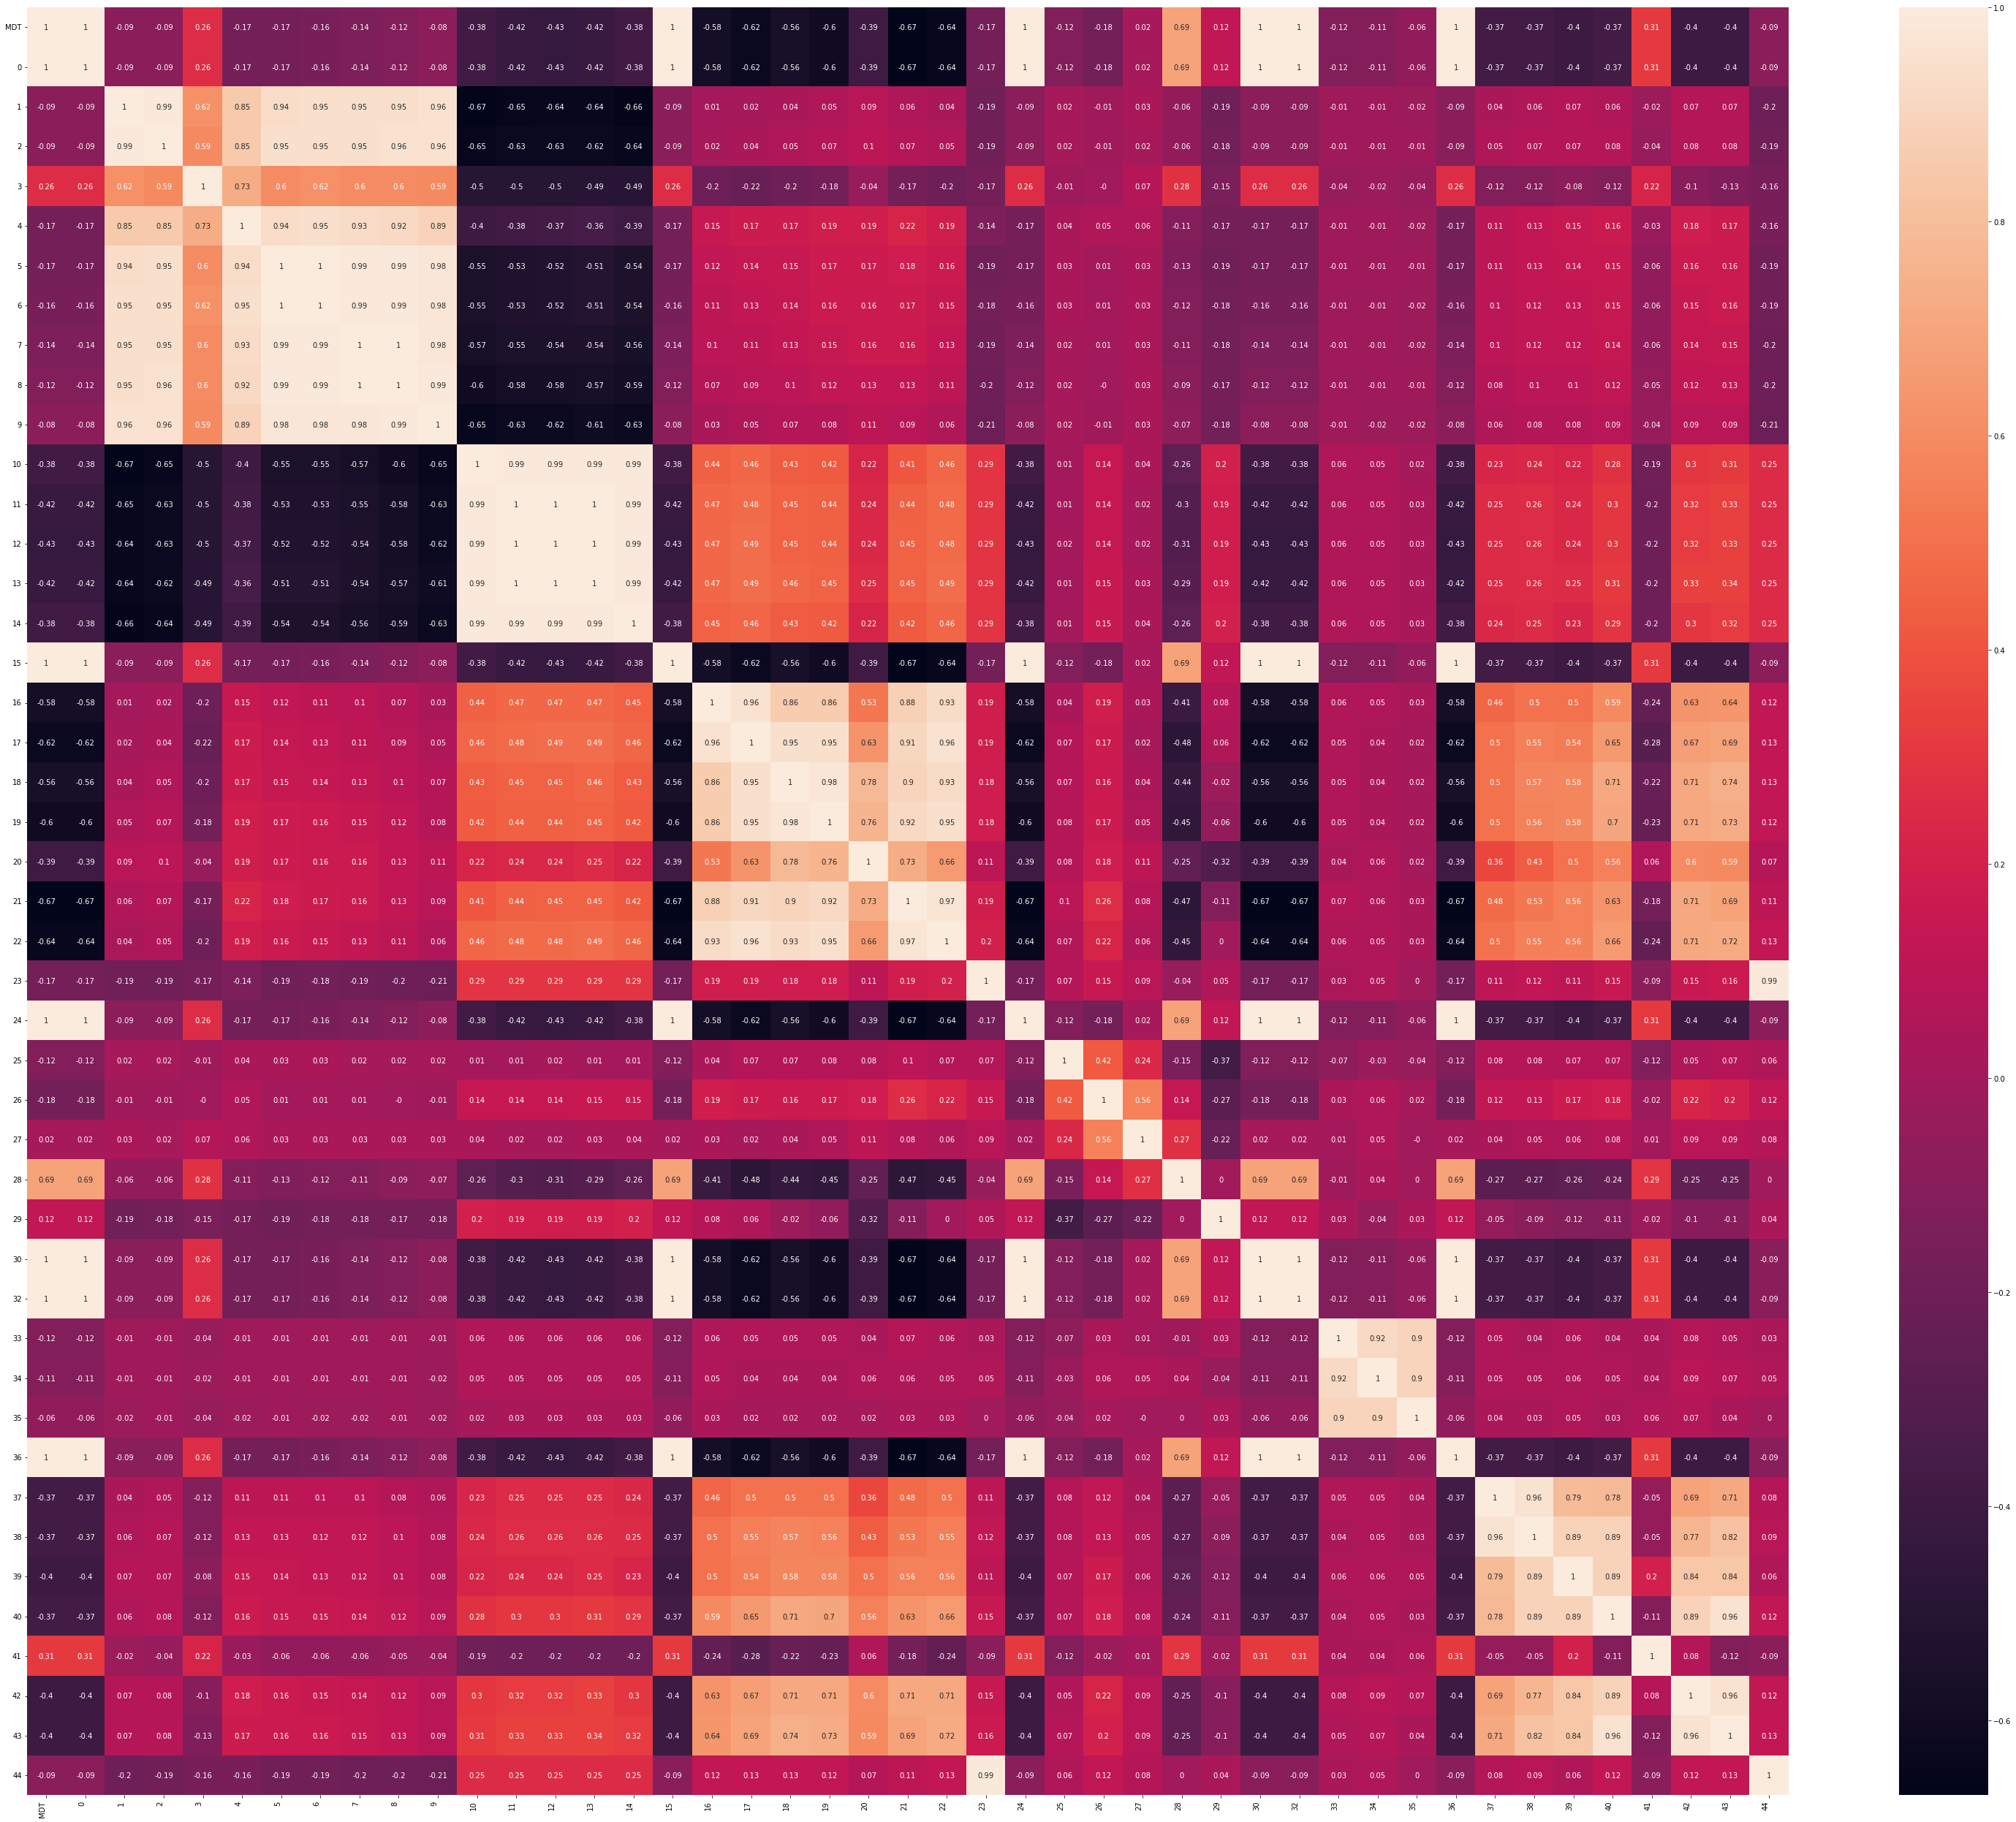

In [45]:
plot_corr(df_rs[features], size=45)
plt.savefig('figs/correlation_matrix.png', dpi=400, bbox_inches='tight')

### PCA

In [ ]:
features = ['GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2_1', 'SWIR2_2', 'SWIR2_3',
            'SWIR2_4', 'SWIR2_5', 'TIR1', 'TIR2', 'TIR3', 'DEM', 'Slope', 
            'NDVI_1984', 'NDVI_1986', 'NDVI_2004', 'NDVI_2021']

In [23]:
features = list(df_rs.columns[2:])
print(features)

['MDT', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


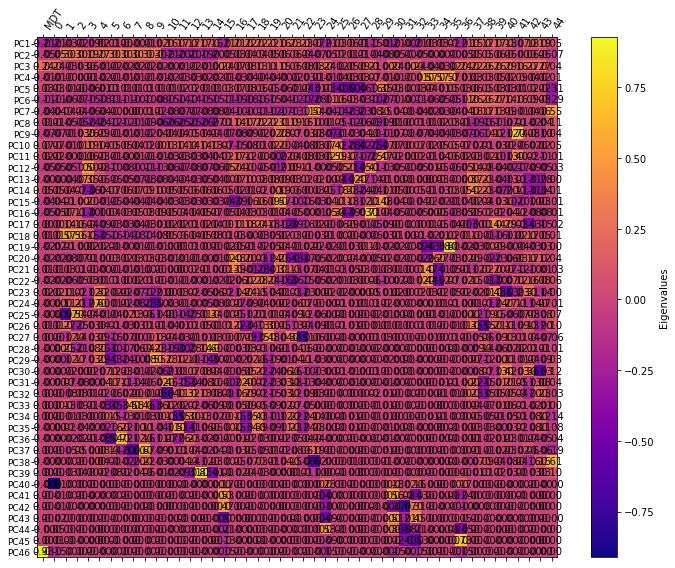

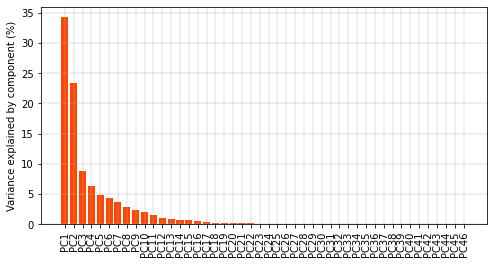

In [24]:
pcs = compute_pca(df_rs, features)
#plt.savefig('figs/eigenvalues_matrix.png', dpi=400, bbox_inches='tight')

In [25]:
def pcs_dataframe(pcs, x, y, n_pcs=pcs.shape[0]):
    
    data = {'X':x, 'Y':y}
    
    components = np.arange(1, n_pcs+1)
    pc = ['PC']*(len(components)+1)

    PCs = []
    for i, k in zip(pc, components):
        PCs.append(i+str(k))

    for n in range(n_pcs):
        data[PCs[n]] = pcs[n][:,0]

    df = pd.DataFrame(data)

    return df

In [26]:
pcs_df=pcs_dataframe(pcs, df_rs.E_utm, df_rs.N_utm)
pcs_df.head(3)

,X,Y,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46
0,398336.153139,9.502136e+06,473.803249,475.123001,427.034968,427.028119,431.758115,424.662473,418.653805,418.524611,...,409.913577,410.402609,410.418504,410.418504,410.418504,410.418504,410.418504,410.418504,410.418504,1149.905185
1,398366.926714,9.502136e+06,471.644921,472.194279,428.755004,428.555450,433.299171,426.754183,420.832397,420.671062,...,408.516964,409.273762,409.278649,409.278649,409.278649,409.278649,409.278649,409.278649,409.278649,1144.015361
2,398397.700289,9.502136e+06,469.686986,470.637115,424.803801,424.521903,429.383605,425.509920,419.905068,419.485362,...,418.153985,418.835315,418.835744,418.835744,418.835744,418.835744,418.835744,418.835744,418.835744,1050.960692


In [31]:
pcs_df.to_csv('RS_PCs.xyz', sep=',', index_label=False, index=False)

## Ternary plots

In [32]:
# defining arguments
variables_rgb = ['PC1', 'PC2', 'PC3'] # a list with the name of the variables in the RGB order;

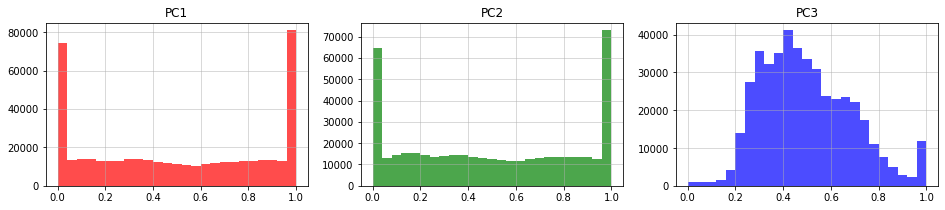

In [33]:
RGB, extent = ternary.grid(pcs_df, variables_rgb, 'X', 'Y', center=0.5, stretch=0.6)

# the first output consists of the grid (M,N 3) used to create the RGB image.
# the second output consists of the extent (coordinates) of the espacial data we intend to plot.

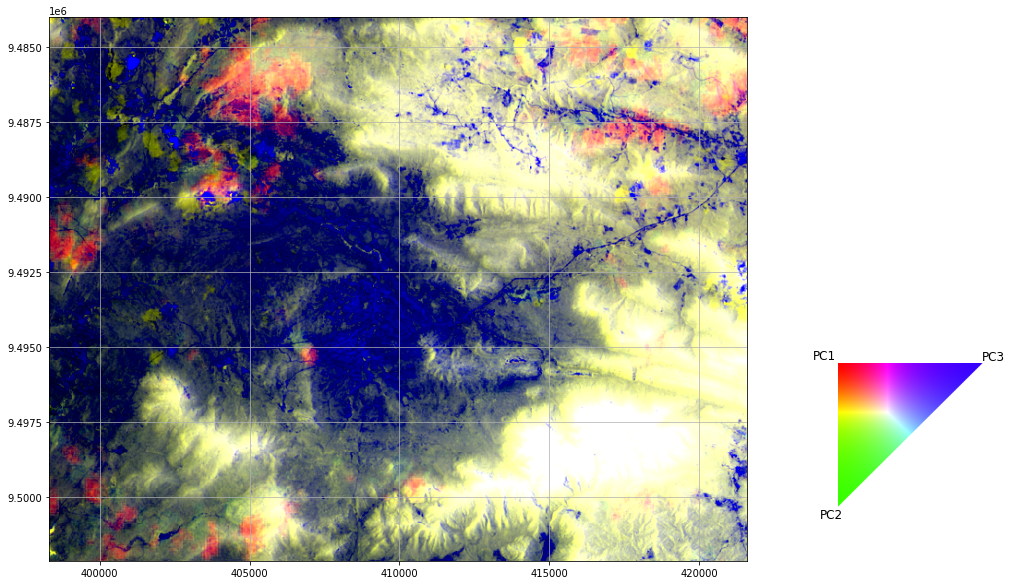

In [34]:
ax = ternary.plot(RGB, variables_rgb, extent, triangle_position=[0.92, 0.2, 0.2, 0.2])
ax.grid(linewidth=0.9, alpha=0.8)
plt.savefig(f'figs/pca_ternary_{variables_rgb[0]+variables_rgb[1]+variables_rgb[2]}.png',
            dpi=400, bbox_inches='tight')

In [ ]:
# defining arguments
# a list with the name of the variables in the RGB order;
variables_rgb = ['PC1', 'PC2', 'PC3'] 

RGB, extent = ternary.grid(df_rs, variables_rgb, 'E_utm', 'N_utm', center=0.5, stretch=.5)

In [ ]:
# the first output consists of the grid (M,N 3) used to create the RGB image.
# the second output consists of the extent (coordinates) of the espacial data we intend to plot.

ax = ternary.plot(RGB, variables_rgb, extent, triangle_position=[0.82, 0.2, 0.2, 0.2])
ax.grid(linewidth=0.9, alpha=0.8)

### Self-organizing maps (SOM)

In [ ]:
from sklearn_som.som import SOM

In [ ]:
#features = ['GREEN', 'DEM', 'SWIR1', 'NDVI_1984', 'NDVI_1986']
#print(features)

In [ ]:
features = list(df_rs.columns[2:])
print(features)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(df_rs[features].values)
# data = df_rs[features].values

In [ ]:
n_clusters=7
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.25, dim=len(features), max_iter=1000)
lito_SOM.fit(data)

In [ ]:
# predição de classes
predictions = lito_SOM.predict(data)

In [ ]:
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']

In [ ]:
# classes weights
fig, ax = plt.subplots()
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(5, 6)
plt.show()

In [ ]:
import matplotlib
id_ = [1, 2, 3, 4, 5,6,7]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)

In [ ]:
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)

In [ ]:
fig, ax=plt.subplots(figsize=(11, int(ratio*11)), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.show()

### Hillshade

In [ ]:
hillshd = hillshade(df_rs['DEM'].values.reshape(ny, nx), 330, 15)

In [ ]:
fig, ax=plt.subplots(figsize=(12, int(ratio*12)), facecolor='w')
slope = df_rs.Slope.values.reshape(ny, nx)
backg = ax.pcolormesh(xs, ys, hillshd, vmin=np.percentile(hillshd, 15), vmax=np.percentile(hillshd, 85),
                      shading='auto', cmap = 'Greys', alpha=1.0)
im=plt.pcolormesh(xs, ys, predictions.reshape(ny,nx), cmap=relcolor, shading='auto', alpha=0.75)

front = ax.pcolormesh(xs, ys, slope, vmin=np.percentile(slope, 15), vmax=np.percentile(slope, 85),
                      shading='auto', cmap = 'Greys', alpha=0.1)
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels,fontsize=7)